#Setup

In [ ]:
!pip install -q tensorflow-text
!pip install -q tensorflow_ranking
!pip install -q ml-metrics

     |████████████████████████████████| 3.4MB 8.4MB/s 
     |████████████████████████████████| 112kB 8.7MB/s 
     |████████████████████████████████| 1.1MB 13.5MB/s 
     |████████████████████████████████| 706kB 27.3MB/s 
     |████████████████████████████████| 645kB 42.9MB/s 
     |████████████████████████████████| 51kB 6.3MB/s 
     |████████████████████████████████| 174kB 42.6MB/s 
     |████████████████████████████████| 102kB 10.0MB/s 
     |████████████████████████████████| 37.6MB 115kB/s 
     |████████████████████████████████| 358kB 52.7MB/s 
     |████████████████████████████████| 1.2MB 54.9MB/s 


In [ ]:
import re
import math
import keras
import random
import ml_metrics
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow_text
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import tensorflow_ranking as tfr

In [ ]:
#load module
module_url = 'https://tfhub.dev/google/universal-sentence-encoder-qa/3' #@param ["https://tfhub.dev/google/universal-sentence-encoder-qa/3","https://tfhub.dev/google/universal-sentence-encoder-multilingual-qa/3"]
model = hub.load(module_url)

In [ ]:
# QUICK LOAD
# from google.colab import drive
# drive.mount('/content/drive')
# base_embed = tf.saved_model.load('/content/drive/My Drive/base USE-QA')
# tf.saved_model.load(model, '/content/drive/My Drive/whole covidbot', signatures=model.signatures)

In [ ]:
#Load spreadsheet with all the answers (its a class because I want to quickly do .reload() or .reload_all() if I change anything)
class Sheet:
  sheet_list = []

  def __init__(self, sheet, url='https://docs.google.com/spreadsheets/d/17HDZ1ftGby51BMFed7BRIWHQkxw_Rd3XY75quW2b0LU/edit#gid=0'):
    Sheet.sheet_list.append(self)
    self.url = re.sub(r'edit.*', 'gviz/tq?tqx=out:csv&sheet='+sheet, url)
    self.data = pd.read_csv(self.url)

  def reload(self):
    self.data = pd.read_csv(self.url)

  def reload_all():
    for sheet in Sheet.sheet_list:
      sheet.reload()


#Fine Tuning Model

In [ ]:
#purpose: take an input question and group it with a pre existing question (question is feature)

#input: [question]
#output: question from faq dataset

#training: 50 random questions and their corresponding answers from the ALL_QUESTIONS sheet
#testing: the rest of questions and answers

##Dataset Prep

In [ ]:
#from https://github.com/wearetriple/ai-faqbot-who/blob/master/Corona_WHO_FAQ.ipynb
def preprocess_sentences(input_sentences):
    input_sentences = [re.sub(r'\xa0', '', str(inp)) for inp in list(input_sentences)]
    return [re.sub(r'(covid-19|covid|n-cov19|sars-cov-19)', 'coronavirus', str(input_sentence), flags=re.I) 
            for input_sentence in input_sentences]

In [ ]:
#Load each sheet for overall and individual testing
all_sheet_names = ['ALL_QUESTIONS', 'UN', 'Harvard_Basic', "East_Tennessee_Children's_Hospital", 'John_Hopkins', 'CDC', 'ECDC', 'NYS', 'NYC', 'NYT']
all_sheet_data = [Sheet(name).data for name in all_sheet_names]

In [ ]:
#Contexts: None (N), Question only (Q), Same answer only (A), current (previous answer in same question) (P), all other answers and questions in same label (ALL)

def get_context(version, data):
  answers = data['Answer']
  questions = data['Question']
  if version == 'N':
    return ['' for answer in answers]
  elif version == 'Q':
    return [questions[ind] for ind in answers.index]
  elif version == 'A':
    return [answer for answer in answers]
  elif version == 'P':
    contexts = []
    ind = 0
    q_indexes = questions.drop_duplicates().index
    while ind < len(q_indexes)-1:
     for num in range(q_indexes[ind], q_indexes[ind+1]):
        if q_indexes[ind+1] - q_indexes[ind] == 1:
          contexts.append(answers[num])
        elif num != q_indexes[ind]:
          contexts.append(answers[num-1])
        else:
          contexts.append(answers[num+1])
     ind += 1
    for num in range(q_indexes[-1], len(questions)):
        if q_indexes[-1] + 1 == len(questions):
          contexts.append(answers[num])
        elif num != q_indexes[-1]:
          contexts.append(answers[num-1])
        else:
          contexts.append(answers[num+1])
    return contexts  
  # elif version == 'ALL':
  #   contexts = []
  #   for ind, answer in enumerate(answers):
  #     same = []
  #     for label_ind, label in enumerate(data['A-Label']):
  #       if label == data['A-Label'][ind]:
  #         same.append(data['Answer'][label_ind])
  #     contexts.append(same)
  #   return padding(contexts)

    

In [ ]:
def get_same_labels(data):
  labels = list(data['Label'])
  questions = preprocess_sentences(data['Question'])
  answers = preprocess_sentences(data['Answer'])

  allOfEm = {}
  ind=0
  last = ''
  same = []
  for ind in range(len(labels)):
    if ind != len(labels)-1:
      if labels[ind] == labels[ind+1]:
        same.append(answers[ind])
      elif labels[ind] == labels[ind-1]:
        same.append(answers[ind])
        allOfEm[labels[ind]]=same
      else:
        same = []
        allOfEm[labels[ind]] = [answers[ind]]
    else:
      if labels[ind] == labels[ind-1]:
        same.append(answers[ind])
        allOfEm[labels[ind]]=same
      else:
        same = []
        allOfEm[labels[ind]] = [answers[ind]]
  return allOfEm

In [ ]:
def get_same_questions(data):
  group = {}
  for idx, question in enumerate(preprocess_sentences(data['Question'])):
    group[question] = data["Label"][idx]
  return group

In [ ]:
all_sheet = all_sheet_data[0] #ALL QUESTIONS

In [ ]:
indexes = random.sample(list(all_sheet.index), 50)
test_sheet = all_sheet.iloc[indexes]
test_sheet.reset_index()
train_sheet = all_sheet.drop(indexes).reset_index()
# print(len(train_sheet['Label'].drop_duplicates()))

In [ ]:
# context_versions = ['N', 'Q', 'A', 'P', 'ALL']
context_versions = ['N', 'Q', 'A', 'P']

testing_ds = {}

#COMMENT OUT LINE
test_sheet = all_sheet

test_sheet.sort_values(inplace=True, by=['Label'])
test_sheet.reset_index(drop=True, inplace=True)

#get answers and context
answers = preprocess_sentences(test_sheet['Answer'])
c = []
for version in context_versions:
  contexts = get_context(version, test_sheet)
  c.append(contexts)

qTol = get_same_questions(test_sheet)
lToA = get_same_labels(test_sheet)
testing_ds[all_sheet_names[0]] = (preprocess_sentences(test_sheet['Question'].drop_duplicates()), answers, c, lToA, qTol)

  

train_questions = train_sheet['Question'].drop_duplicates()

training_response = []
training_response.extend(preprocess_sentences(train_questions))
training_response.extend(preprocess_sentences(train_sheet['Answer']))

training_labels = []
training_labels.extend([train_sheet['Label'][ind] for ind in train_questions.index])
training_labels.extend(train_sheet['Label'])

num_classes=110
training_ds = (training_response, keras.utils.to_categorical(training_labels, num_classes))

In [ ]:
#ALL QUESTIONS TRAINING
train_sheet = all_sheet
train_questions = train_sheet['Question'].drop_duplicates()

training_response = []
training_response.extend(preprocess_sentences(train_questions))
training_response.extend(preprocess_sentences(train_sheet['Answer']))

training_labels = []
training_labels.extend([train_sheet['Label'][ind] for ind in train_questions.index])
training_labels.extend(train_sheet['Label'])

num_classes=110
training_ds = (training_response, keras.utils.to_categorical(training_labels, num_classes))

##Classifier

In [ ]:
#embed = hub.load(module_url)
#response embedder fine tuning
# labels = keras.utils.to_categorical(answers_context_ds['ALL_QUESTIONS'][1], num_classes=num_classes)
input_layer = keras.Input(shape=(), dtype='string')
# input_layer2 = keras.Input(shape=(), dtype='string')
# embed_layer = embed_layer_res()([input_layer, input_layer2])
# embed_layer = keras.layers.Lambda(embed_func_res, output_shape=(512,))(input_layer)
embed_layer = hub.KerasLayer(embed, input_shape=[], dtype=tf.string, output_shape=[512,], trainable=True)(input_layer)
dense1 = keras.layers.Dense(256, activation='relu')(embed_layer)
dropout = keras.layers.Dropout(0.2)(dense1)
dense2 = keras.layers.Dense(128, activation='relu')(dropout)
outputs = keras.layers.Dense(num_classes, activation='softmax')(dense2)

model = keras.Model(inputs=input_layer, outputs=outputs)

model.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics = [tf.metrics.CategoricalAccuracy(),
               tf.metrics.Precision(top_k=10), 
               tfr.keras.metrics.MRRMetric(),
               tfr.keras.metrics.MeanAveragePrecisionMetric(topn=100)]
)       
                                             

In [ ]:
history2= model.fit(
    x=np.array(training_ds[0]),
    y=np.array(training_ds[1]),
    epochs=20
)

Epoch 1/20


26/26 [==============================] - 129s 5s/step - loss: 4.7003 - categorical_accuracy: 0.0326 - precision: 0.0208 - mrr_metric: 0.0974 - mean_average_precision_metric: 0.0968
Epoch 2/20
26/26 [==============================] - 129s 5s/step - loss: 4.6999 - categorical_accuracy: 0.0919 - precision: 0.0325 - mrr_metric: 0.1790 - mean_average_precision_metric: 0.1786
Epoch 3/20
26/26 [==============================] - 130s 5s/step - loss: 4.6991 - categorical_accuracy: 0.0786 - precision: 0.0369 - mrr_metric: 0.1795 - mean_average_precision_metric: 0.1793
Epoch 4/20
26/26 [==============================] - 130s 5s/step - loss: 4.6973 - categorical_accuracy: 0.0629 - precision: 0.0354 - mrr_metric: 0.1733 - mean_average_precision_metric: 0.1730
Epoch 5/20
26/26 [==============================] - 127s 5s/step - loss: 4.6920 - categorical_accuracy: 0.0580 - precision: 0.0369 - mrr_metric: 0.1645 - mean_average_precision_metric: 0.1642
Epoch 6/20
26/26 [==============================] -

##evaluate

In [ ]:
def shape_all_pred(questions, all_predictions, groups, questionToLabel):
  all_predictions = list(all_predictions)
  for idx, prediction in enumerate(all_predictions):
    all_predictions[idx] = prediction[::-1]
    # all_predictions[idx] = prediction[:len(groups[questionToLabel[questions[idx]]])]
  return np.array(all_predictions)

def MRR(questions, all_predictions, groups, questionToLabel):
  #get reciprocal ranks of all predictions
  ranks = []
  flag = True
  for idx, predictions in enumerate(all_predictions):
    for prediction in predictions:
      if prediction in groups[questionToLabel[questions[idx]]]:
        ranks.append(1/(np.where(predictions==prediction)[0]+1))
        flag=False
        break
    if flag:
      ranks.append(0)
  
  #take mean of reciprocal ranks
  return sum(ranks)[0]/len(ranks)

# ml_metrics.mapk(all groups[question] sorted by questions, all_predictions, 10)

def results(questions, max_predictions, groups, questionToLabel):
  positives = 0
  negatives = 0
  for idx, prediction in enumerate(max_predictions):
    if prediction in groups[questionToLabel[questions[idx]]]:
      positives += 1
      # print('CORRECT:', groups[questionToLabel[questions[idx]]], prediction)
    else:
      negatives += 1
      # print('INCORRECT:', groups[questionToLabel[questions[idx]]], prediction)
  return positives, negatives

No, there will not be a national app for contact tracing. There are many options available now, and it is up to each state and individual to decide which tools best fit their needs.
Studies to date suggest that the virus that causes coronavirus is mainly transmitted through contact with respiratory droplets rather than through the air. See previous answer on “How does coronavirus spread?”
How Does Coronavirus (coronavirus) Spread?


0.8016811862063415

In [ ]:
def round_(n,d=3):
  if len(str(n)) < 3+d:
    return n
  if str(n)[2+d] >= str(5):
    return math.ceil(n*(10**d))/10**d
  return math.floor(n*(10**d))/10**d

In [ ]:
from tqdm.notebook import tqdm
base_embed = hub.load(module_url)

base_evaluations = {} #per sheet: MRR:, MAP@10, MAP@1, Positives:, Negatives:
for ind, sheet in tqdm(enumerate(testing_ds)):
  sheet = testing_ds[sheet]
  all_evals = []
  question_embeddings = base_embed.signatures['question_encoder'](
      tf.constant(sheet[0])
        )['outputs']
  for context in tqdm(sheet[2]):
    evals = {}
    response_embeddings = base_embed.signatures['response_encoder'](
      input=tf.constant(sheet[1]),
      context=tf.constant(context)
    )['outputs']
    all_predictions = np.array(sheet[1])[np.inner(question_embeddings, response_embeddings).argsort(axis=1)]
    shaped_predictions = shape_all_pred(sheet[0], all_predictions, sheet[3], sheet[4])
    max_predictions = np.array(sheet[1])[np.argmax(np.inner(question_embeddings, response_embeddings), axis=1)]
    positives, negatives = results(sheet[0], max_predictions, sheet[3], sheet[4])
    evals['MRR'] = MRR(sheet[0], shaped_predictions, sheet[3], sheet[4])
    evals['MAP@10'] = ml_metrics.mapk([sheet[3][sheet[4][question]] for question in sheet[0]], shaped_predictions, 100)
    # evals['MAP@1'] = round_(ml_metrics.mapk([sheet[3][sheet[4][question]] for question in sheet[0]], shaped_predictions, 1))
    evals['Positives'] = positives
    evals['Negatives'] = negatives
    all_evals.append(evals)
    
  base_evaluations[all_sheet_names[ind]] = all_evals #N, Q, A, P, ALL

In [ ]:
base_evaluations

{'ALL_QUESTIONS': [{'MAP@10': 0.21414929094506305,
   'MRR': 0.7251241907907408,
   'Negatives': 106,
   'Positives': 167},
  {'MAP@10': 0.24579615433457136,
   'MRR': 0.8148928298243896,
   'Negatives': 74,
   'Positives': 199},
  {'MAP@10': 0.24124142740808222,
   'MRR': 0.8091995187865738,
   'Negatives': 78,
   'Positives': 195},
  {'MAP@10': 0.24268204987851097,
   'MRR': 0.8016811862063415,
   'Negatives': 81,
   'Positives': 192}]}

In [ ]:
from tqdm.notebook import tqdm


evaluations = {} #per sheet: MRR:, MAP@10, MAP@1, Positives:, Negatives:
for ind, sheet in tqdm(enumerate(testing_ds)):
  sheet = testing_ds[sheet]
  all_evals = []
  question_embeddings = embed.signatures['question_encoder'](
      tf.constant(sheet[0])
        )['outputs']
  for context in tqdm(sheet[2]):
    evals = {}
    response_embeddings = embed.signatures['response_encoder'](
      input=tf.constant(sheet[1]),
      context=tf.constant(context)
    )['outputs']
    all_predictions = np.array(sheet[1])[np.inner(question_embeddings, response_embeddings).argsort(axis=1)]
    shaped_predictions = shape_all_pred(sheet[0], all_predictions, sheet[3], sheet[4])
    max_predictions = np.array(sheet[1])[np.argmax(np.inner(question_embeddings, response_embeddings), axis=1)]
    positives, negatives = results(sheet[0], max_predictions, sheet[3], sheet[4])
    evals['MRR'] = round_(MRR(sheet[0], shaped_predictions, sheet[3], sheet[4]))
    evals['MAP@10'] = round_(ml_metrics.mapk([sheet[3][sheet[4][question]] for question in sheet[0]], shaped_predictions, 100))
    # evals['MAP@1'] = round_(ml_metrics.mapk([sheet[3][sheet[4][question]] for question in sheet[0]], shaped_predictions, 1))/////////////////////
    evals['Positives'] = positives
    evals['Negatives'] = negatives
    all_evals.append(evals)
    
  evaluations[all_sheet_names[ind]] = all_evals #N, Q, A, P, ALL 

In [ ]:
base_evaluations

{'ALL_QUESTIONS': [{'MAP@10': 0.21414929094506305,
   'MRR': 0.7251241907907408,
   'Negatives': 106,
   'Positives': 167},
  {'MAP@10': 0.24579615433457136,
   'MRR': 0.8148928298243896,
   'Negatives': 74,
   'Positives': 199},
  {'MAP@10': 0.24124142740808222,
   'MRR': 0.8091995187865738,
   'Negatives': 78,
   'Positives': 195},
  {'MAP@10': 0.24268204987851097,
   'MRR': 0.8016811862063415,
   'Negatives': 81,
   'Positives': 192}]}

In [ ]:
evaluations

{'ALL_QUESTIONS': [{'MAP@10': 0.028,
   'MRR': 0.25,
   'Negatives': 39,
   'Positives': 234},
  {'MAP@10': 0.026, 'MRR': 0.219, 'Negatives': 32, 'Positives': 241},
  {'MAP@10': 0.026, 'MRR': 0.23, 'Negatives': 34, 'Positives': 239},
  {'MAP@10': 0.026, 'MRR': 0.236, 'Negatives': 35, 'Positives': 238}]}

In [ ]:
tf.saved_model.save(embed, '/content/drive/My Drive/whole covidbot', signatures=embed.signatures)

INFO:tensorflow:Assets written to: /content/drive/My Drive/whole covidbot/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/whole covidbot/assets


In [ ]:
new = tf.saved_model.load('/content/drive/My Drive/whole covidbot')

In [ ]:
new.signatures

_SignatureMap({'question_encoder': <ConcreteFunction signature_wrapper(input) at 0x7F0D5002EA20>, 'response_encoder': <ConcreteFunction signature_wrapper(context, input) at 0x7F0D6617DE10>, 'default': <ConcreteFunction signature_wrapper(input) at 0x7F0D4D519320>})

In [ ]:
data = {'Questions':testing_ds['ALL_QUESTIONS'][0]} 
data = pd.DataFrame.from_dict(data)
data.to_csv('/content/drive/My Drive/Question Sheet Oct 2020.csv')

In [ ]:
evaluations #20

{'ALL_QUESTIONS': [{'MAP@10': 0.631,
   'MRR': 0.695,
   'Negatives': 18,
   'Positives': 25},
  {'MAP@10': 0.699, 'MRR': 0.792, 'Negatives': 12, 'Positives': 31},
  {'MAP@10': 0.717, 'MRR': 0.781, 'Negatives': 13, 'Positives': 30},
  {'MAP@10': 0.717, 'MRR': 0.782, 'Negatives': 13, 'Positives': 30}]}

In [ ]:
base_evaluations #3

{'ALL_QUESTIONS': [{'MAP@10': 0.583,
   'MRR': 0.642,
   'Negatives': 22,
   'Positives': 21},
  {'MAP@10': 0.651, 'MRR': 0.731, 'Negatives': 15, 'Positives': 28},
  {'MAP@10': 0.642, 'MRR': 0.711, 'Negatives': 16, 'Positives': 27},
  {'MAP@10': 0.644, 'MRR': 0.711, 'Negatives': 16, 'Positives': 27}]}

#Plot Similarity Graphs
uses default signatures

In [ ]:
#edit list to have questions and answers in same list
allQ = Sheet('ALL_QUESTIONS').data
labels = [10,11,12,13,14]

newL = []
for label in labels:
  indexes = list(np.where(allQ['Label']==label)[0])
  inds = random.sample(indexes, 2)
  newL.append(allQ['Question'][inds[0]])
  for ind in inds:
    newL.append(allQ['Answer'][ind])

In [ ]:
#taken from https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/semantic_similarity_with_tf_hub_universal_encoder.ipynb#scrollTo=h1FFCTKm7ba4
def embed(input):
  return model2(input)

def plot_similarity(labels, features, rotation):
  corr = np.inner(features, features)
  sns.set(font_scale=1.2)
  g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
  g.set_xticklabels(labels, rotation=rotation)
  g.set_title("Semantic Textual Similarity")

def run_and_plot(messages_):
  message_embeddings_ = embed(messages_)
  for i, message in enumerate(messages_):
    if len(message) >= 30:
      messages_[i] = ''.join(message[:30])+'...'
  plot_similarity(messages_, message_embeddings_, 90)

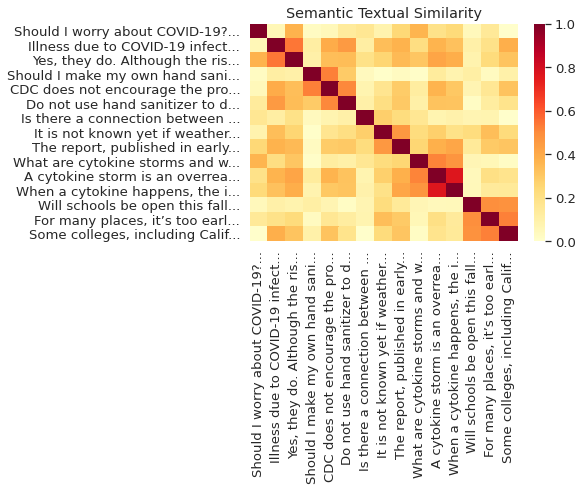

In [ ]:
#BASE MODEL
run_and_plot(newL)

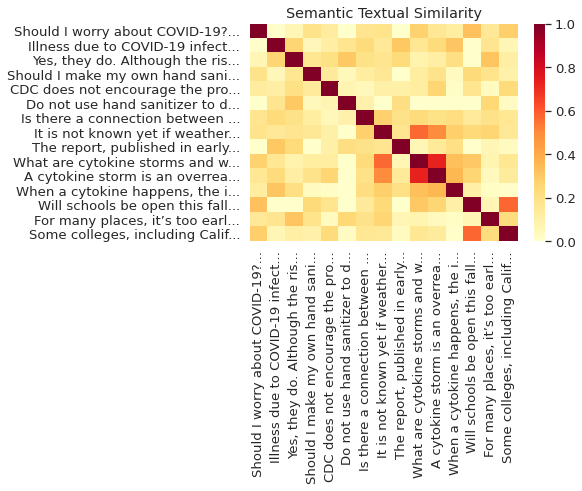

In [ ]:
#TRAINED MODEL
run_and_plot(newL)

In [ ]:
model2 = tf.saved_model.load('/content/drive/My Drive/whole covidbot')